zmienną objaśniana - liczba nadań w konkretnym dniu kolejnego tygodnia/miesiąca

a) DimDates - Plik CSV - Baza danych z informacjami o datach (Rok, Miesiąc, Dzień, Dzień tygodnia, Weekend, Święto itp.) 

b) PostingVolume - Plik Parquet - Baza danych z dziennymi nadaniami (Od 1 stycznia 2021 do 31 Sierpnia 2023). 
Dane są zgrupowane per dzień w podziale na dwie usługi APM i COURIER wraz z odseparowanym klientem X. Ten klient co miesiąc pod koniec poprzedniego miesiąca dostarcza nam swoją prognozę zamówień.

c) Clients_Orders - Plik EXCEL - Dane dostarczane przez klienta (X) od początku 2023 roku. Dane dotyczące nadchodzącego miesiąca są wysyłane pod koniec poprzedniego. Plik zawiera ilość zamówień oczekiwanych przez klienta każdego dnia.

d) Zadanie_Dane_Temperatura - Folder z Plikami CSV - Folder zawiera pliki CSV, gdzie w każdym pliku (dla każdego miesiąca - między styczniem 2021 a sierpniem 2023 roku) przechowywane są dane dotyczące temperatur (maksymalna, średnia, minimalna temperatura) oraz opadów (deszczu i śniegu). Dane są zebrane dla dwóch miast: WARSZAWA i KRAKÓW

In [410]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [411]:
# dates
keep_cols = '''dateId
dateWeekOfMonth
dateQuarter
dateIsWeekend
dateIsHolidayInd
dateWeekDayStartsMonday'''.split('\n')
dates_df = pd.read_csv('dimDates_Task.csv', sep=';', usecols=keep_cols)
dates_df

,dateId,dateWeekOfMonth,dateQuarter,dateIsWeekend,dateIsHolidayInd,dateWeekDayStartsMonday
0,2020-10-04,2,4,1,0,7
1,2020-08-10,3,3,0,0,1
2,2020-09-30,5,3,0,0,3
3,2020-05-21,4,2,0,0,4
4,2020-05-27,5,2,0,0,3
...,...,...,...,...,...,...
1456,2020-03-05,1,1,0,0,4
1457,2020-04-17,3,2,0,0,5
1458,2020-11-04,1,4,0,0,3
1459,2020-11-16,3,4,0,0,1


In [412]:
# create timestamp
dates_df['dateId'] = pd.to_datetime(dates_df['dateId'], format='%Y-%m-%d')
dates_df.rename(columns={'dateId': 'DateId'}, inplace=True)
dates_df['timestamp'] = dates_df['DateId'].astype('int64') / 10**9
dates_df

,DateId,dateWeekOfMonth,dateQuarter,dateIsWeekend,dateIsHolidayInd,dateWeekDayStartsMonday,timestamp
0,2020-10-04,2,4,1,0,7,1.601770e+09
1,2020-08-10,3,3,0,0,1,1.597018e+09
2,2020-09-30,5,3,0,0,3,1.601424e+09
3,2020-05-21,4,2,0,0,4,1.590019e+09
4,2020-05-27,5,2,0,0,3,1.590538e+09
...,...,...,...,...,...,...,...
1456,2020-03-05,1,1,0,0,4,1.583366e+09
1457,2020-04-17,3,2,0,0,5,1.587082e+09
1458,2020-11-04,1,4,0,0,3,1.604448e+09
1459,2020-11-16,3,4,0,0,1,1.605485e+09


In [413]:
# load Posing Volume
posting_volumes = pd.read_parquet('Posting_Volumes.parquet', engine='fastparquet')
print(posting_volumes.info())
print(posting_volumes['postingDateFk'].describe())
print(posting_volumes['Product'].describe())
print(posting_volumes['Customer'].describe())  
print(posting_volumes['Volume'].describe())

<class 'pandas.core.frame.DataFrame'>
Index: 3892 entries, 0 to 3891
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   postingDateFk  3892 non-null   object 
 1   Product        3892 non-null   object 
 2   Customer       3892 non-null   object 
 3   Volume         3892 non-null   float64
dtypes: float64(1), object(3)
memory usage: 152.0+ KB
None
count         3892
unique         973
top       20210101
freq             4
Name: postingDateFk, dtype: object
count     3892
unique       2
top        APM
freq      1946
Name: Product, dtype: object
count     3892
unique       2
top          X
freq      1946
Name: Customer, dtype: object
count      3892.000000
mean     143536.470533
std       87923.899208
min        -876.759667
25%       80150.606161
50%      130202.764469
75%      193735.702340
max      582617.649973
Name: Volume, dtype: float64


In [414]:
# replace negative Volume with 0
posting_volumes['Volume'] = posting_volumes['Volume'].clip(lower=0)
posting_volumes['Volume'].describe()

count      3892.000000
mean     143537.078153
std       87922.904784
min           0.000000
25%       80150.606161
50%      130202.764469
75%      193735.702340
max      582617.649973
Name: Volume, dtype: float64

In [415]:
print(posting_volumes['Customer'].unique())

print(len(posting_volumes[posting_volumes['Customer'] == 'Rest']))
print(len(posting_volumes[posting_volumes['Customer'] == 'X']))


['X' 'Rest']
1946
1946


In [416]:
posting_volumes['timestamp'] = pd.to_datetime(posting_volumes['postingDateFk'], format='%Y%m%d').astype('int64') / 10**9

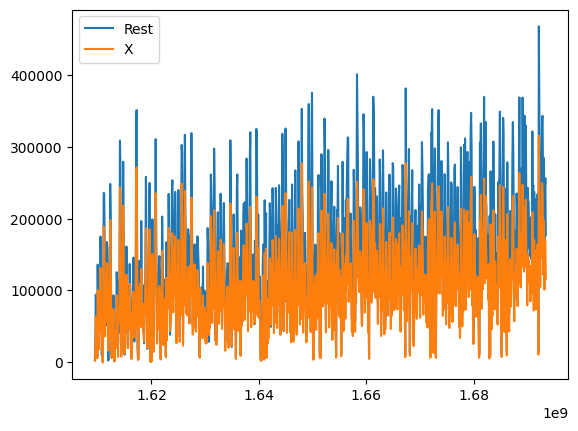

Rest mean: 153856.34695320146
X mean: 109925.20117393955


43931.145779261904

In [417]:
plot_df = posting_volumes[posting_volumes['Product'] == 'APM']
x1 = plot_df[plot_df['Customer'] == 'Rest']['timestamp']
y1 = plot_df[plot_df['Customer'] == 'Rest']['Volume']
x2 = plot_df[plot_df['Customer'] == 'X']['timestamp']
y2 = plot_df[plot_df['Customer'] == 'X']['Volume']# + 25000
plt.plot(x1, y1, label='Rest')  
plt.plot(x2, y2, label='X')
plt.legend()
plt.show()
print('Rest mean:', y1.mean())
print('X mean:', y2.mean())
y1.mean() - y2.mean()

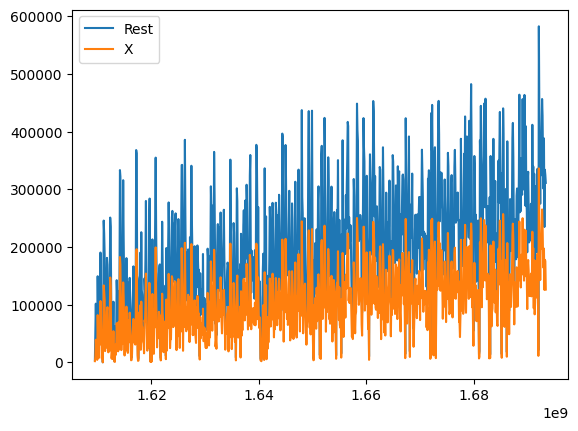

Rest mean: 202792.23578628295
X mean: 107574.52869961406


95217.70708666889

In [418]:
plot_df = posting_volumes[posting_volumes['Product'] == 'COURIER']
x1 = plot_df[plot_df['Customer'] == 'Rest']['timestamp']
y1 = plot_df[plot_df['Customer'] == 'Rest']['Volume']
x2 = plot_df[plot_df['Customer'] == 'X']['timestamp']
y2 = plot_df[plot_df['Customer'] == 'X']['Volume']# * 1.4 +40000
plt.plot(x1, y1, label='Rest')  
plt.plot(x2, y2, label='X')
plt.legend()
plt.show()
print('Rest mean:', y1.mean())
print('X mean:', y2.mean())
y1.mean() - y2.mean()

Zmienna objaśniana będzie różna dla różnych klientów

Klient X ma mniej nadań w porównaniu do innych klientów - uwzględnić średnią liczbę nadań dla ostatnich czterech kwartali

In [419]:
posting_volumes.head()

,postingDateFk,Product,Customer,Volume,timestamp
0,20210101,APM,X,2401.301452,1.609459e+09
1,20210102,APM,X,20195.515269,1.609546e+09
2,20210103,APM,X,63561.702640,1.609632e+09
3,20210104,APM,X,40310.645622,1.609718e+09
4,20210105,APM,X,54800.879137,1.609805e+09


In [420]:
posting_volumes['postingDateFk'] = pd.to_datetime(posting_volumes['postingDateFk'], format='%Y%m%d')
posting_volumes.rename(columns={'postingDateFk': 'DateId'}, inplace=True)

In [421]:
# skoro volume jest różny dla każdego klienta, musimy zrobić średnią z ostatnich 3, 6, 9, 12 miesięcy
def get_customer_avg_volume(row, df, months_before=3, months_exclude=1):
    """
    Filters the DataFrame to include data from `months_before` months before
    the date in the row, excluding `months_exclude` months before that date.
    """
    date = row['DateId']
    start_date = date - pd.DateOffset(months=months_before)
    end_date = date - pd.DateOffset(months=months_exclude)
    avg_volume = df[(df['DateId'] > start_date) & (df['DateId'] <= end_date) & (df['Customer'] == row['Customer'])]['Volume'].mean() #[f'last{months_before}months']
    return avg_volume if not pd.isnull(avg_volume) else 0

# add avg_volume for each row and concatenate results
for _, row in posting_volumes.iterrows():
    posting_volumes.loc[_,'VolumeAvgLast3months'] = get_customer_avg_volume(row, posting_volumes, months_before=3)
    posting_volumes.loc[_,'VolumeAvgLast6months'] = get_customer_avg_volume(row, posting_volumes, months_before=6)
    posting_volumes.loc[_,'VolumeAvgLast9months'] = get_customer_avg_volume(row, posting_volumes, months_before=9)
    posting_volumes.loc[_,'VolumeAvgLast12months'] = get_customer_avg_volume(row, posting_volumes, months_before=12)

posting_volumes

,DateId,Product,Customer,Volume,timestamp,VolumeAvgLast3months,VolumeAvgLast6months,VolumeAvgLast9months,VolumeAvgLast12months
0,2021-01-01,APM,X,2401.301452,1.609459e+09,0.000000,0.000000,0.000000,0.000000
1,2021-01-02,APM,X,20195.515269,1.609546e+09,0.000000,0.000000,0.000000,0.000000
2,2021-01-03,APM,X,63561.702640,1.609632e+09,0.000000,0.000000,0.000000,0.000000
3,2021-01-04,APM,X,40310.645622,1.609718e+09,0.000000,0.000000,0.000000,0.000000
4,2021-01-05,APM,X,54800.879137,1.609805e+09,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
3887,2023-08-27,COURIER,Rest,388307.576620,1.693094e+09,237141.931700,227409.030280,222914.099026,215526.659874
3888,2023-08-28,COURIER,Rest,234648.548766,1.693181e+09,239943.524489,227822.202670,223007.320111,215230.740137
3889,2023-08-29,COURIER,Rest,333947.920499,1.693267e+09,238593.964391,227572.669954,223084.485187,215313.289292
3890,2023-08-30,COURIER,Rest,324682.815539,1.693354e+09,237993.776931,227643.895045,223130.083569,215568.673202


In [422]:


# last6months = posting_volumes[posting_volumes['DateId'] > posting_volumes['DateId'] - pd.DateOffset(months=6)]
# last9months = posting_volumes[posting_volumes['DateId'] > posting_volumes['DateId'] - pd.DateOffset(months=9)]
# last12months = posting_volumes[posting_volumes['DateId'] > posting_volumes['DateId'] - pd.DateOffset(months=12)]

# previous2months_grouped = previous2months.groupby('Customer')['Volume'].mean().reset_index()
# last6months_grouped = last6months.groupby('Customer')['Volume'].mean().reset_index()
# last9months_grouped = last9months.groupby('Customer')['Volume'].mean().reset_index()
# last12months_grouped = last12months.groupby('Customer')['Volume'].mean().reset_index()
# print(previous2months_grouped.head())
# print(last6months_grouped.head())
# print(last9months_grouped.head())
# print(last12months_grouped.head())

# posting_volumes = posting_volumes.merge(previous2months_grouped, on='Customer', how='left', suffixes=('', 'AvgPrevious2months')) # 2 as we predict the next month we don't have data for the next month
# posting_volumes = posting_volumes.merge(last6months_grouped, on='Customer', how='left', suffixes=('', 'AvgLast6months'))
# posting_volumes = posting_volumes.merge(last9months_grouped, on='Customer', how='left', suffixes=('', 'AvgLast9months'))
# posting_volumes = posting_volumes.merge(last12months_grouped, on='Customer', how='left', suffixes=('', 'AvgLast12months'))

# posting_volumes.head()

In [423]:
# last_date = posting_volumes['DateId'].max()
# last3months = posting_volumes[posting_volumes['DateId'] > last_date - pd.DateOffset(months=3)]
# last6months = posting_volumes[posting_volumes['DateId'] > last_date - pd.DateOffset(months=6)]
# last9months = posting_volumes[posting_volumes['DateId'] > last_date - pd.DateOffset(months=9)]
# last12months = posting_volumes[posting_volumes['DateId'] > last_date - pd.DateOffset(months=12)]

# last3months_grouped = last3months.groupby('Customer')['Volume'].mean().reset_index()
# last6months_grouped = last6months.groupby('Customer')['Volume'].mean().reset_index()
# last9months_grouped = last9months.groupby('Customer')['Volume'].mean().reset_index()
# last12months_grouped = last12months.groupby('Customer')['Volume'].mean().reset_index()
# print(last3months_grouped.head())
# print(last6months_grouped.head())
# print(last9months_grouped.head())
# print(last12months_grouped.head())

# posting_volumes = posting_volumes.merge(last3months_grouped, on='Customer', how='left', suffixes=('', 'AvgLast3months'))
# posting_volumes = posting_volumes.merge(last6months_grouped, on='Customer', how='left', suffixes=('', 'AvgLast6months'))
# posting_volumes = posting_volumes.merge(last9months_grouped, on='Customer', how='left', suffixes=('', 'AvgLast9months'))
# posting_volumes = posting_volumes.merge(last12months_grouped, on='Customer', how='left', suffixes=('', 'AvgLast12months'))

# posting_volumes.head()

In [424]:
x_client_predictions = pd.read_csv('X_ClientORDERS.csv', sep=';')
x_client_predictions['timestamp'] = pd.to_datetime(x_client_predictions['DateId'], format='%Y%m%d').astype('int64') / 10**9
x_client_predictions['Orders'] = x_client_predictions['Orders'].str.replace(',', '.').astype(float)
x_client_predictions.head()

,DateId,Orders,timestamp
0,20230101,161366.0647,1.672531e+09
1,20230102,296627.3247,1.672618e+09
2,20230103,378262.3686,1.672704e+09
3,20230104,320907.5834,1.672790e+09
4,20230105,93098.2144,1.672877e+09


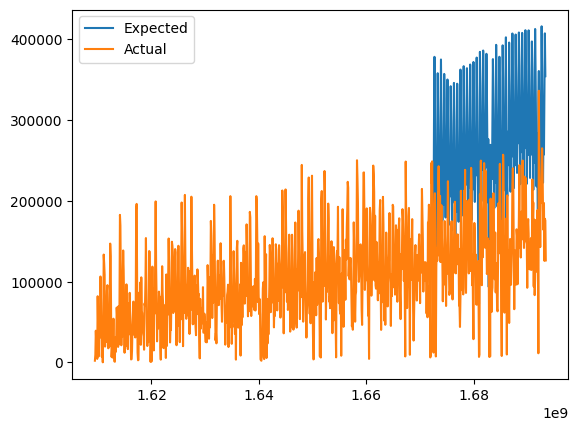

Expected mean: 275094.3768284711
Actual mean: 107574.52869961406


167519.84812885703

In [425]:
plot_df = posting_volumes[posting_volumes['Product'] == 'COURIER']
x1 = x_client_predictions['timestamp']
y1 = x_client_predictions['Orders']
x2 = plot_df[plot_df['Customer'] == 'X']['timestamp']
y2 = plot_df[plot_df['Customer'] == 'X']['Volume']# * 1.4 +40000
plt.plot(x1, y1, label='Expected')  
plt.plot(x2, y2, label='Actual')
plt.legend()
plt.show()
print('Expected mean:', y1.mean())
print('Actual mean:', y2.mean())
y1.mean() - y2.mean()

Client's expectations are twice higher than historical data

------------------------------------------------------------------

In [426]:
weather_df = pd.DataFrame()
for file in os.listdir('Zadanie_Dane_Temperatura'):
    temp_df = pd.read_csv(f'Zadanie_Dane_Temperatura/{file}',sep=',', header=0)
    # merge to dateId
    temp_df['year'] = temp_df['Rok'].astype('int64')
    temp_df['month'] = temp_df['Miesiac'].astype('int64')
    temp_df['day'] = temp_df['Dzien'].astype('int64')
    temp_df['DateId'] = pd.to_datetime(temp_df[["year","month","day"]])
    temp_df.drop(columns=['Rok','Miesiac','Dzien'], inplace=True)
    temp_df.drop(columns=['year','month','day'], inplace=True)
    temp_df.drop('Nazwa stacji', axis=1, inplace=True)
    
    weather_df = pd.concat([weather_df, temp_df], axis=0)
weather_df.head()

,Maksymalna temperatura dobowa,Minimalna temperatura dobowa,Srednia temperatura dobowa,Suma dobowa opadow [mm],Pokrywa sniegu [cm],DateId
0,0.5,-1.2,-0.5,0.0,0,2021-01-01
1,4.4,-1.6,0.8,0.0,0,2021-01-02
2,4.0,-0.9,1.1,0.0,0,2021-01-03
3,4.9,-0.7,1.7,7.1,0,2021-01-04
4,3.7,1.4,2.5,4.3,0,2021-01-05


Combine the dataframes:

DimDates + PostingVolume + Weather

Clients_Orders - model bazowy

In [427]:
print(posting_volumes.shape)
print(weather_df.shape)
print(dates_df.shape)

(3892, 9)
(1946, 6)
(1461, 7)


In [433]:
dates_df['DateId'] = pd.to_datetime(dates_df['DateId'], format='%Y%m%d')
posting_volumes['DateId'] = pd.to_datetime(posting_volumes['DateId'], format='%Y%m%d')
weather_df['DateId'] = pd.to_datetime(weather_df['DateId'], format='%Y-%m-%d')
dataset = dates_df.merge(posting_volumes, on='DateId', how='right')
dataset = dataset.merge(weather_df, on='DateId', how='left')

# sort by date
dataset.sort_values('DateId', inplace=True)
dataset.to_csv('dataset.csv', index=False, sep=';')
# get random sample
dataset

,DateId,dateWeekOfMonth,dateQuarter,dateIsWeekend,dateIsHolidayInd,dateWeekDayStartsMonday,timestamp_x,Product,Customer,Volume,timestamp_y,VolumeAvgLast3months,VolumeAvgLast6months,VolumeAvgLast9months,VolumeAvgLast12months,Maksymalna temperatura dobowa,Minimalna temperatura dobowa,Srednia temperatura dobowa,Suma dobowa opadow [mm],Pokrywa sniegu [cm]
0,2021-01-01,1,1,0,1,5,1.609459e+09,APM,X,2401.301452,1.609459e+09,0.000000,0.000000,0.000000,0.000000,0.5,-1.2,-0.5,0.0,0
1947,2021-01-01,1,1,0,1,5,1.609459e+09,APM,Rest,3124.683698,1.609459e+09,0.000000,0.000000,0.000000,0.000000,0.9,-1.2,-0.2,0.0,0
1946,2021-01-01,1,1,0,1,5,1.609459e+09,APM,Rest,3124.683698,1.609459e+09,0.000000,0.000000,0.000000,0.000000,0.5,-1.2,-0.5,0.0,0
5839,2021-01-01,1,1,0,1,5,1.609459e+09,COURIER,Rest,3849.234586,1.609459e+09,0.000000,0.000000,0.000000,0.000000,0.9,-1.2,-0.2,0.0,0
5838,2021-01-01,1,1,0,1,5,1.609459e+09,COURIER,Rest,3849.234586,1.609459e+09,0.000000,0.000000,0.000000,0.000000,0.5,-1.2,-0.5,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3890,2023-08-31,5,3,0,0,4,1.693440e+09,APM,Rest,176930.766304,1.693440e+09,234555.478871,227336.030468,222954.818265,215409.342967,23.2,14.8,17.4,0.1,0
1945,2023-08-31,5,3,0,0,4,1.693440e+09,APM,X,116088.673276,1.693440e+09,140380.377832,136233.377205,133987.900671,129612.840991,21.7,14.8,16.7,0.0,0
1944,2023-08-31,5,3,0,0,4,1.693440e+09,APM,X,116088.673276,1.693440e+09,140380.377832,136233.377205,133987.900671,129612.840991,23.2,14.8,17.4,0.1,0
5837,2023-08-31,5,3,0,0,4,1.693440e+09,COURIER,X,126193.170258,1.693440e+09,140380.377832,136233.377205,133987.900671,129612.840991,21.7,14.8,16.7,0.0,0


In [399]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7784 entries, 0 to 7783
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   DateId                         7784 non-null   datetime64[ns]
 1   dateWeekOfMonth                7784 non-null   int64         
 2   dateQuarter                    7784 non-null   int64         
 3   dateIsWeekend                  7784 non-null   int64         
 4   dateIsHolidayInd               7784 non-null   int64         
 5   dateWeekDayStartsMonday        7784 non-null   int64         
 6   timestamp_x                    7784 non-null   float64       
 7   Product                        7784 non-null   object        
 8   Customer                       7784 non-null   object        
 9   Volume                         7784 non-null   float64       
 10  timestamp_y                    7784 non-null   float64       
 11  VolumeAvgLast3months  

In [400]:
dataset.drop('timestamp_y', inplace=True, axis=1)
dataset.rename(columns={'timestamp_x': 'timestamp'}, inplace=True)
# check for missing values
dataset.isnull().sum()

DateId                           0
dateWeekOfMonth                  0
dateQuarter                      0
dateIsWeekend                    0
dateIsHolidayInd                 0
dateWeekDayStartsMonday          0
timestamp                        0
Product                          0
Customer                         0
Volume                           0
VolumeAvgLast3months             0
VolumeAvgLast6months             0
VolumeAvgLast9months             0
VolumeAvgLast12months            0
Maksymalna temperatura dobowa    0
Minimalna temperatura dobowa     0
Srednia temperatura dobowa       0
Suma dobowa opadow [mm]          0
Pokrywa sniegu [cm]              0
dtype: int64

In [401]:
dataset[dataset['DateId'].between(pd.to_datetime('2021-01-01'),pd.to_datetime('2023-08-31'))].isnull().sum()

DateId                           0
dateWeekOfMonth                  0
dateQuarter                      0
dateIsWeekend                    0
dateIsHolidayInd                 0
dateWeekDayStartsMonday          0
timestamp                        0
Product                          0
Customer                         0
Volume                           0
VolumeAvgLast3months             0
VolumeAvgLast6months             0
VolumeAvgLast9months             0
VolumeAvgLast12months            0
Maksymalna temperatura dobowa    0
Minimalna temperatura dobowa     0
Srednia temperatura dobowa       0
Suma dobowa opadow [mm]          0
Pokrywa sniegu [cm]              0
dtype: int64

In [402]:
dataset = dataset[dataset['DateId'].between(pd.to_datetime('2021-01-01'),pd.to_datetime('2023-08-31'))]
print(dataset.isnull().sum())
print(dataset.info())

DateId                           0
dateWeekOfMonth                  0
dateQuarter                      0
dateIsWeekend                    0
dateIsHolidayInd                 0
dateWeekDayStartsMonday          0
timestamp                        0
Product                          0
Customer                         0
Volume                           0
VolumeAvgLast3months             0
VolumeAvgLast6months             0
VolumeAvgLast9months             0
VolumeAvgLast12months            0
Maksymalna temperatura dobowa    0
Minimalna temperatura dobowa     0
Srednia temperatura dobowa       0
Suma dobowa opadow [mm]          0
Pokrywa sniegu [cm]              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 7784 entries, 0 to 7783
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   DateId                         7784 non-null   datetime64[ns]
 1   dateWeekOfMont

In [403]:
dataset.to_csv('dataset.csv', index=False, sep=';')

In [404]:
# Prepare for training

# convert object columns to category
for col in dataset.select_dtypes(include='object').columns:
    dataset[col] = dataset[col].astype('category')

# reset index
dataset.reset_index(drop=True, inplace=True)

# send Volume (label) to the end
dataset = pd.concat([dataset.drop('Volume', axis=1), dataset['Volume']], axis=1)

dataset.drop('DateId', axis=1, inplace=True)

dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7784 entries, 0 to 7783
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   dateWeekOfMonth                7784 non-null   int64   
 1   dateQuarter                    7784 non-null   int64   
 2   dateIsWeekend                  7784 non-null   int64   
 3   dateIsHolidayInd               7784 non-null   int64   
 4   dateWeekDayStartsMonday        7784 non-null   int64   
 5   timestamp                      7784 non-null   float64 
 6   Product                        7784 non-null   category
 7   Customer                       7784 non-null   category
 8   VolumeAvgLast3months           7784 non-null   float64 
 9   VolumeAvgLast6months           7784 non-null   float64 
 10  VolumeAvgLast9months           7784 non-null   float64 
 11  VolumeAvgLast12months          7784 non-null   float64 
 12  Maksymalna temperatura dobowa  778

In [405]:
# save the dataframe
dataset.to_pickle('dataset.pkl')

In [406]:
df = pd.read_pickle('dataset.pkl')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7784 entries, 0 to 7783
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   dateWeekOfMonth                7784 non-null   int64   
 1   dateQuarter                    7784 non-null   int64   
 2   dateIsWeekend                  7784 non-null   int64   
 3   dateIsHolidayInd               7784 non-null   int64   
 4   dateWeekDayStartsMonday        7784 non-null   int64   
 5   timestamp                      7784 non-null   float64 
 6   Product                        7784 non-null   category
 7   Customer                       7784 non-null   category
 8   VolumeAvgLast3months           7784 non-null   float64 
 9   VolumeAvgLast6months           7784 non-null   float64 
 10  VolumeAvgLast9months           7784 non-null   float64 
 11  VolumeAvgLast12months          7784 non-null   float64 
 12  Maksymalna temperatura dobowa  778